# Major US Power Outage Duration Prediction

**Tommy Shen**

## Summary of Findings


### Introduction
The model in this notebook attempts to predict the duration of a major power outage in the US via linear regression. This is a very practical response variable for electricity companies to predict, since having an estimate of how long it will take to restore a power outage allows for more transparency with customers. Furthermore, patterns shown by the model might reveal critical flaws in infrastructure that hinder power restoration efforts.

Model performance and fairness is evaluated using mean absolute error, which is an appropriate metric since an error value with the same units as our response variable (seconds) is easy to interpret and has a distribution that can be visualized meaningfully.

Features un-available at prediction time include demand loss and restoration time. The number of customers affected could also be considered among the unavailable features but it's unclear whether or not this number is pre-determined using by the number of registered customers in an affected grid or if this data is obtained after the outage.

### Baseline Model
The baseline model uses the anomaly level and cause of an outage as predictors in linear regression. Since anomaly level is quantitative and cause is nominal the only transformation required is one hot encoding. On average, predictions made by this model were off by 40-45 minutes which is somewhat good, but visualization of the residuals showed that some predictions were far from the actual durations. Additionally, the coefficient of determination was very low suggesting that a linear model is likley not appropriate.

### Final Model
The final model keeps anomaly level and one hot encoded causes as predictors and introduces climate region and time of day as additional predictors. The old linear regression estimator is replaced with a regression tree. The time of day is binarized to encode whether or not an outage began outside of typical working hours (8AM-6PM) and climate region is one-hot encoded.

### Fairness Analysis
Two fairness assessment tests are conducted.

First, I hypothesized that the most under-represented region in the training set would have a larger mean absolute error than the most over-represented region. A permutation test of the difference in mean absolute error was conduted with the following hypotheses:
* $H_0$: The mean absolute error for outage duration predictions is the same for the most overrepresented and most underrepresented regions
* $H_1$: The mean absolute error for outage duration predictions is greater for the most underrepresented region than for the most overrepresented region
With a significance level of $\alpha=0.05$, we failed to reject the null hypothesis.

Next, an ANOVA of the mean absolute error was conducted to compare errors among all regions The hypotheses were:
* $H_0$: The mean absolute errors of every region is equal
* $H_1$: At least one region has a mean absolute error that is different than the others
With a significance level of $\alpha=0.05$, we failed to reject the null hypothesis.

While these tests don't show any signs of unfairness, we cannot be for certain that the model doesn't perform better for some groups than others.

## Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

The cell below reads the outage excel data and reformats it to a tidy rectangular form as done in project 3.

In [2]:
#Data preview from project 3
outages = pd.read_excel('outage.xlsx')
#Set proper column names, remove empty header cells, drop empty 'variables' column
outages.columns = outages.loc[4].rename(None)
outages = outages[6:]
outages = outages.drop(['variables'], axis=1)
#Set index to OBS
outages = outages.set_index('OBS')
outages.iloc[0:6,0:9]

C:\Users\thoma\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE
OBS,,,,,,,,,
1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00
2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00
3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00
4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00
6,2010,11,Minnesota,MN,MRO,East North Central,-1.4,cold,2010-11-13 00:00:00


Many variables included in the dataset have little relation to power-outage duration, such as land-use, free-form text elaboration on outage cause, and event nomenclature.

As per the description of variables, electricity pricing and servicing is all aggregated by the state, thus having multicollinearity with the state variable.

Some of the columns in the dataset are either co-dependent with the response variable or are unavailable at prediction time, such as restoration time and demand loss. These features are dropped along with the other irrelevant and uninformative columns.

In [3]:
outages.columns

Index(['YEAR', 'MONTH', 'U.S._STATE', 'POSTAL.CODE', 'NERC.REGION',
       'CLIMATE.REGION', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY',
       'OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE',
       'OUTAGE.RESTORATION.TIME', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL',
       'HURRICANE.NAMES', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW',
       'CUSTOMERS.AFFECTED', 'RES.PRICE', 'COM.PRICE', 'IND.PRICE',
       'TOTAL.PRICE', 'RES.SALES', 'COM.SALES', 'IND.SALES', 'TOTAL.SALES',
       'RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN', 'RES.CUSTOMERS',
       'COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS', 'RES.CUST.PCT',
       'COM.CUST.PCT', 'IND.CUST.PCT', 'PC.REALGSP.STATE', 'PC.REALGSP.USA',
       'PC.REALGSP.REL', 'PC.REALGSP.CHANGE', 'UTIL.REALGSP', 'TOTAL.REALGSP',
       'UTIL.CONTRI', 'PI.UTIL.OFUSA', 'POPULATION', 'POPPCT_URBAN',
       'POPPCT_UC', 'POPDEN_URBAN', 'POPDEN_UC', 'POPDEN_RURAL',
       'AREAPCT_URBAN', 'AREAPCT_UC', 'PCT_LAND', 'PCT_WATER_TOT',
       'PCT

In [4]:
#Drop uninformative commercial and land-use columns
outages = outages.drop(outages.columns[18:], axis=1)
#Drop redundant time, name-related, and explanatory columns
outages = outages.drop(['U.S._STATE', 'HURRICANE.NAMES', 'CAUSE.CATEGORY.DETAIL'], axis=1)
outages = outages.rename(columns={'POSTAL.CODE': 'STATE'})
#Drop features unavailable at prediction time
outages = outages.drop(['OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME', 'DEMAND.LOSS.MW'], axis=1)
outages.columns

Index(['YEAR', 'MONTH', 'STATE', 'NERC.REGION', 'CLIMATE.REGION',
       'ANOMALY.LEVEL', 'CLIMATE.CATEGORY', 'OUTAGE.START.DATE',
       'OUTAGE.START.TIME', 'CAUSE.CATEGORY', 'OUTAGE.DURATION',
       'CUSTOMERS.AFFECTED'],
      dtype='object')

The remaining variables all have a plausible connection to power outage duration and could potentially be used as predictors. Missing values in the response column, OUTAGE.DURATION are dropped as they are not helpful to the model.

In [5]:
outages = outages.dropna(subset=['OUTAGE.DURATION'])

### Baseline Model

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

This first linear regression model considers the region's anomaly level, which measures the general climate temperature trend at the time of occurrence and the cause of the outage.

It seems logical that the duration of a power outage depends on the current pan-American weather trends and the type of event causing the outage; information which is captured by the selected columns.

In [7]:
df = outages[['ANOMALY.LEVEL', 'CAUSE.CATEGORY', 'OUTAGE.DURATION']]
df = df.rename(columns={'CAUSE.CATEGORY': 'CAUSE', 
                        'OUTAGE.DURATION': 'DURATION'})
df['ANOMALY.LEVEL'] = df['ANOMALY.LEVEL'].apply(float)
df['DURATION'] = df['DURATION'].apply(float)
df.head()

,ANOMALY.LEVEL,CAUSE,DURATION
OBS,,,
1,-0.3,severe weather,3060.0
2,-0.1,intentional attack,1.0
3,-1.5,severe weather,3000.0
4,-0.1,severe weather,2550.0
5,1.2,severe weather,1740.0


Anomaly level is quantitative, while cause category is nominal. For the prediction task, cause category is one hot encoded while anomaly level is left as is.

In [8]:
#Split data into training and testing sets
X = df.drop('DURATION', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, df['DURATION'])
#Define transformations for all columns
preproc = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ['CAUSE'])],
    remainder='passthrough'
)
#Pipeline with transformations and model
pl = Pipeline([
    ('preproc', preproc),
    ('lr', LinearRegression())
])

In [9]:
#Fit and evaluate model
pl.fit(X_train, y_train)
preds = pl.predict(X_test)
mae = (preds - y_test).abs().mean()
r_sq = pl.score(X_test, y_test)
mae, r_sq

(2178.158899718165, 0.27649647381457687)

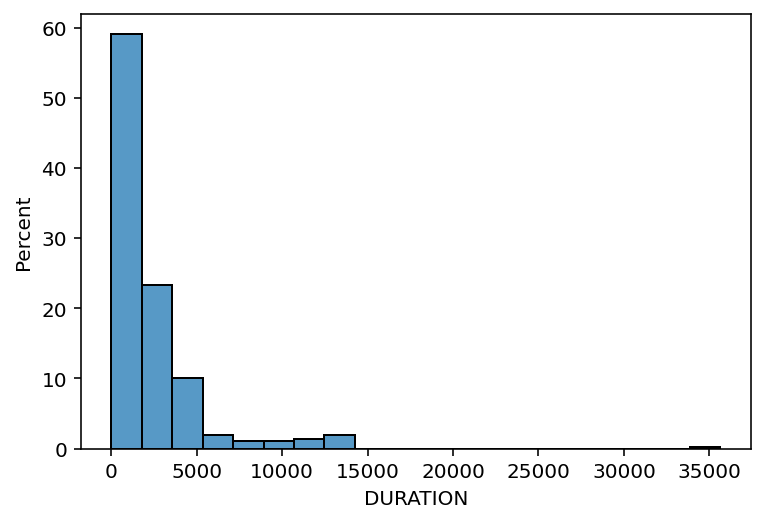

In [10]:
#Plot histogram of MAE
sns.histplot((preds-y_test).abs(), stat='percent', bins=20)
plt.show()

The baseline model performed well for most cases as reflected by a mean absolute error around 40min, however there were also predictions that were very far off. Based on these results the model seems somewhat capable of generalizing to most unseen data but utterly fails for some cases. The low $R^2$ suggests that a linear model is not appropriate so ultimately, the model needs significant improvement.

### Final Model

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

To improve the original model, the nominal variable climate region and quantitative start time column are added as a predictors.

States and regions that are more prone to harsh weather such as hurricanes, are more prepared and better-equipped when it comes to restoration, thus we should expect outages that occur in certain climate regions to have shorter restoration times. One hot encoding is used once again to quantify this categorical data.

In the investigation in project 3, it was found that power outages that began outside of normal working hours (8AM-6PM) took longer to restore than outages that began during them. Power outage start times are binarized to encode whether or not an outage began outside of working hours.

The linear regression estimator is replaced by a regression tree due to the low $R^2$ obtained in the original model.

In [12]:
#Add CLIMATE.REGION column to df
df = df.assign(REGION=outages['CLIMATE.REGION'])
df = df.assign(TIME=outages['OUTAGE.START.TIME'])
df.head()

,ANOMALY.LEVEL,CAUSE,DURATION,REGION,TIME
OBS,,,,,
1,-0.3,severe weather,3060.0,East North Central,17:00:00
2,-0.1,intentional attack,1.0,East North Central,18:38:00
3,-1.5,severe weather,3000.0,East North Central,20:00:00
4,-0.1,severe weather,2550.0,East North Central,04:30:00
5,1.2,severe weather,1740.0,East North Central,02:00:00


In [13]:
#Extract hour from start time to proper format for Binarizer
df['TIME'] = df['TIME'].apply(lambda x: x.hour)
df.head()

,ANOMALY.LEVEL,CAUSE,DURATION,REGION,TIME
OBS,,,,,
1,-0.3,severe weather,3060.0,East North Central,17
2,-0.1,intentional attack,1.0,East North Central,18
3,-1.5,severe weather,3000.0,East North Central,20
4,-0.1,severe weather,2550.0,East North Central,4
5,1.2,severe weather,1740.0,East North Central,2


In [14]:
#Merge start times and regions column to input datasets originally split for the baseline model
X_train = X_train.merge(df['TIME'], left_index=True, right_index=True)
X_test = X_test.merge(df['TIME'], left_index=True, right_index=True)
X_train = X_train.merge(df['REGION'], left_index=True, right_index=True)
X_test = X_test.merge(df['REGION'], left_index=True, right_index=True)
#Define transformations for all columns
preproc = ColumnTransformer([
    ('bin', Binarizer(threshold=16), ['TIME']),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ['CAUSE', 'REGION'])],
    remainder='passthrough')

In [15]:
#Perform CV for the best max-depth for Decision Tree Regressor
hp = {
    'max_depth': [2,3,4,5,6,7,8,9,10],
    'min_samples_split': [2,3,4,5],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}
searcher = GridSearchCV(DecisionTreeRegressor(), hp, cv=8)
preproc.fit(X_train)
proc_X_train = preproc.transform(X_train)

searcher.fit(proc_X_train, y_train)
depth = searcher.best_params_['max_depth']
crit = searcher.best_params_['criterion']
samples = searcher.best_params_['min_samples_split']
depth, crit, samples

(2, 'squared_error', 2)

In [16]:
#Pipeline with transformations and model
pl = Pipeline([
    ('preproc', preproc),
    ('dtr', DecisionTreeRegressor(max_depth=depth, criterion=crit, min_samples_split=samples))
])

In [17]:
#Fit and evaluate model
pl.fit(X_train, y_train)
preds = pl.predict(X_test)
mae = (preds - y_test).abs().mean()
mae

2269.167169567524

There was a slight improvement to the final model's predictions from the baseline, with the mean absolute error reducing from 40min to around 25-30min. With predictions that are typically only off by about half an hour, an electricity company can report fairly correct estimates for power restoration times.

To achieve better performance, I propose excluding outliers from the training set as outliers tend to hold much leverage over regression tasks thus they could have negative impact on the prediction task here

### Fairness Analysis

The primary concern for fairness in major power outage duration prediction is whether or not the model performs better for some geo-located climate regions than others. As per usual, mean absolute error is used to assess the performance within each region.

If unfairness is present we should expect to see worse performance on regions that have a disproportionately small representation in the training set.

In [18]:
#Determine the region that has the highest over/under representation in the training set
reg_props = X_train['REGION'].value_counts() / X_train['REGION'].value_counts().sum()
reg_prop_diffs = outages['CLIMATE.REGION'].value_counts() / outages['CLIMATE.REGION'].value_counts().sum() - reg_props
over_region = reg_prop_diffs.idxmax()
under_region = reg_prop_diffs.idxmin()
print(f'Most represented region: {over_region}')
print(f'Least represented region: {under_region}')

Most represented region: South
Least represented region: Central


More formally, a permutation test is run for the variables _over_region_ and _under_region_ defined above (may change due to randomness when splitting in the baseline model). The hypotheses are:
* $H_0$: The mean absolute error for outage duration predictions is the same for the most overrepresented and most underrepresented regions
* $H_1$: The mean absolute error for outage duration predictions is greater for the most underrepresented region than for the most overrepresented region

The test statistic used is difference in mean absolute error and the significance level of $\alpha=0.05$ is used.

In [19]:
#Assign prediction and response columns to testing dataset
f_df = X_test.assign(ABS_ERR=(preds-y_test).abs())
#Filter dataset into regions of interest
f_df = f_df[X_test['REGION'].isin([over_region, under_region])]
f_df.head()

,ANOMALY.LEVEL,CAUSE,TIME,REGION,ABS_ERR
OBS,,,,,
1030,0.5,equipment failure,15,South,437.377210
297,-0.7,fuel supply emergency,8,Central,2342.583333
258,0.5,severe weather,19,South,2347.516637
855,-0.5,intentional attack,12,Central,707.377210
1433,-0.4,severe weather,16,South,1012.516637


In [20]:
#Function to compute test stat: Difference in MAE
def diff_MAE(df):
    mae_table = df.groupby('REGION')['ABS_ERR'].mean()
    return mae_table[under_region] - mae_table[over_region] #Larger values suggest more error in underrepresented region

#Observed test stat
obs = diff_MAE(f_df)
#Simulate test stats via permutation
f_copy = f_df.copy()
results = np.array([])
reps = 10000
for _ in range(reps):
    shuffled = np.random.permutation(f_copy['REGION'])
    f_copy['REGION'] = shuffled
    results = np.append(results, diff_MAE(f_copy))
results[:10]

array([ -154.35645535, -1128.38049719,  -118.77664186,  -848.34159157,
        -639.12559727,   438.87836367,   -90.36230333,  -129.06242979,
         207.32504852,   231.1086183 ])

In [21]:
#Compute p-value
(results >= obs).mean()

0.2679

The p-value was greater than the significance level thus we fail to reject the null hypothesis. It seems that the difference in mean absolute error between the region with the highest overrepresentation is the same as the region with the greatest underrepresentation in training. This test alone however, is insufficient to conclude that the model is fair to all regions since it only examines a single pairing of regions.

To supplement the previous assessment of fairness, a test considering all regions is conducted. Below an ANOVA test of the mean absolute error is run on all the original testing columns. The hypotheses are:
* $H_0$: The mean absolute errors of every region is equal
* $H_1$: At least one region has a mean absolute error that is different than the others
Once again, a significance level of $\alpha=0.05$ is used.

In [22]:
from scipy.stats import f_oneway

In [23]:
#Assign column with absolute errors
anova_df = X_test.assign(ABS_ERR=(preds-y_test).abs())
anova_df.head()

,ANOMALY.LEVEL,CAUSE,TIME,REGION,ABS_ERR
OBS,,,,,
530,0.3,intentional attack,0,Northeast,731.377210
955,-0.9,severe weather,16,Northeast,2166.483363
424,0.6,intentional attack,23,Northwest,69.377210
1030,0.5,equipment failure,15,South,437.377210
139,-0.9,severe weather,19,East North Central,2122.483363


In [24]:
#Separate errors by region
samples = []
for reg, reg_df in anova_df.groupby('REGION'):
    samples.append(reg_df['ABS_ERR'].to_numpy())
#Run ANOVA
f_oneway(*samples)

F_onewayResult(statistic=1.5302524236438295, pvalue=0.14515202905304284)

Once again, the p-value is greater than the significance level. We fail to reject the null hypothesis, it appears that the mean absolute errors for each region are very similar. While both these tests seem to suggest that the model is fair, other tests may reveal the contrary. Ultimately, we cannot conclude that the model is fair for every region without further testing.